# String Algorithms

## 1 - 单模式串匹配

### 1.1 -  暴力解法

In [1]:
def BruteForce(text, pattern):
    res = []
    for i in range(len(text) - len(pattern) + 1):
        j = 0
        while j < len(pattern):
            if text[i + j] != pattern[j]:
                break
            j += 1
        if j == len(pattern):
            res.append(i)
    return res

In [2]:
text = 'abcabcababac'
pattern = 'ab'
print(BruteForce(text, pattern))

### 2 - RabinKarp算法

In [3]:
class RabinKarp:
    def __init__(self, text, pattern):
        self.text = text
        self.pattern = pattern
        self.p = 1000000007 # p是一个很大的质数
        self.x = 236 # x是区间[1, p-1]任意一个数即可
        
    def PolyHash(self, s):
        hash = 0
        for i in range(len(s) - 1, -1, -1):
            hash = (hash * self.x + ord(s[i])) % self.p
        return hash
    
    # 预先计算主串中每一个长度为m的子串的哈希值
    def PreComputeHashes(self):
        n = len(self.text)
        m = len(self.pattern)
        H = [0] * (n - m + 1)
        H[-1] = self.PolyHash(self.text[n - m:])
        y = pow(self.x, m, self.p)
        for i in range(n - m - 1, -1, -1):
            H[i] = (self.x * H[i + 1] + ord(self.text[i]) - ord(self.text[i + m]) * y ) % self.p
        return H
    
    def Match(self):
        p_hash = self.PolyHash(self.pattern)
        H = self.PreComputeHashes()
        res = []
        for i in range(len(H)):
            if H[i] == p_hash:
                res.append(i)
        return res

In [4]:
# test case
text = 'abcabcababac'
pattern = 'ab'
S = RabinKarp(text, pattern)
print(S.Match())

[0, 3, 6, 8]


### 3 - KMP算法

In [5]:
class KMP:
    def PrefixFunction(self, string):
        prefix = [0] * len(string)
        border = 0
        for i in range(1, len(string)):
            while border > 0 and string[i] != string[border]:
                border = prefix[border - 1]
            if string[i] == string[border]:
                border += 1
            else:
                border = 0
            prefix[i] = border
        return prefix
    
    def Match(self, text, pattern):
        s = pattern + '#' + text
        prefix = self.PrefixFunction(s)
        res = []
        for i in range(len(pattern) + 1, len(s)):
            if prefix[i] == len(pattern):
                res.append(i - 2 * len(pattern))
        return res

In [6]:
# test case
text = 'abcabcababac'
pattern = 'ab'
S = KMP()
print(S.Match(text, pattern))

[0, 3, 6, 8]


### 4 - BM算法

In [7]:
class BM:
    def __init__(self, text, pattern):
        self.text = text
        self.pattern = pattern
        self.suffix = [-1] * len(pattern)
        self.prefix = [False] * len(pattern)
        
    def GenerateBadChar(self):
        bad_char = [-1] * 256
        for i in range(len(self.pattern)):
            bad_char[ord(self.pattern[i])] = i
        return bad_char
    
    def GenerateGS(self):
        m = len(self.pattern)
        for i in range(m - 1): # pattern[0:i + 1]
            j = i
            k = 0# 后缀长度
            # 从模式串尾部与pattern[0:i + 1]从后往前逐个进行字符的比较
            # 最后k为公共后缀的长度，j+1为其起始位置
            while j >=0 and self.pattern[j] == self.pattern[m - 1 -k]:
                j -= 1
                k += 1
                self.suffix[k] = j + 1
            # 如果起始位置为0，则该后缀同时也是模式串的前缀
            if j == -1:
                self.prefix[k] = True
    
    def MoveByGS(self, bc_pos):
        # 传入的是坏字符对应的模式串中的字符下标
        m = len(self.pattern)
        k = m - bc_pos - 1 # 好后缀长度
        if k < m and self.suffix[k] != -1:
            return bc_pos + 1 - self.suffix[k]
        for i in range(k - 1, 0, -1):
            if self.prefix[i]:
                return m - i
        return m
    
    def Match(self):
        bad_char = self.GenerateBadChar()
        self.GenerateGS()
        n = len(self.text)
        m = len(self.pattern)
         
        res = []
        i = 0
        while i <= n - m:
            j = m - 1
            while j >=0 and text[i + j] == pattern[j]:
                j -= 1
            if j == -1:
                res.append(i)
                # 如果模式串匹配成功，则移动至使其最长公共前后缀对齐
                i += self.MoveByGS(j)
            else:
                move_len1 = j - bad_char[ord(self.text[i + j])]
                move_len2 = 0
                if j < m - 1:
                    move_len2 = self.MoveByGS(j)
                i += max(move_len1, move_len2)
        
        del bad_char
        del self.suffix
        del self.prefix
        return res

In [8]:
text = 'ATATA'
pattern = 'ATA'
S = BM(text, pattern)
print(S.Match())

[0, 2]


In [9]:
text = "abcacabcbcbacabc"
pattern = "cbacabc"
S = BM(text, pattern)
print(S.Match())

[9]


## 2 - 多模式串匹配

### 1 - Trie树

In [10]:
class Trie:
    class TrieNode:
        def __init__(self, label):
            self.label = label
            self.children = {}
            self.isWord = False # 该结点是否为一个模式串的结尾字符
            self.length = -1 # 若为一个模式串的结尾字符，则记录该模式串长度
    
    # 定义根节点
    def __init__(self):
        self.root = self.TrieNode('')
    
    # 插入一个模式串
    def Insert(self, pattern):
        curr = self.root
        for i in range(len(pattern)):
            symbol = pattern[i]
            if not curr.children.__contains__(symbol):
                curr.children[symbol] = self.TrieNode(symbol)
            curr = curr.children[symbol]
        curr.isWord = True
        curr.length = len(pattern)
    
    # 主串匹配
    def Match(self, text):
        res = []
        for i in range(len(text)):
            curr = self.root
            for j in range(i, len(text)):
                symbol = text[j]
                if not curr.children.__contains__(symbol):
                    break
                curr = curr.children[symbol]
                if curr.isWord:
                    pos = j - curr.length + 1
                    res.append((i, text[pos:j+1]))
        return res

In [11]:
#test case
text = 'abcdc'
patterns = ['abcd', 'bcd', 'c']
trie = Trie()
for pattern in patterns:
    trie.Insert(pattern)
print(trie.Match(text))

[(0, 'abcd'), (1, 'bcd'), (2, 'c'), (4, 'c')]


### 2 - AC自动机

1. 构造Trie树
2. 添加fail指针

In [12]:
from queue import Queue
class ACAutomation:
    class ACNode:
        def __init__(self, label):
            self.label = label
            self.children = {}
            self.isWord = False # 该结点是否为一个模式串的结尾字符
            self.length = -1 # 若为一个模式串的结尾字符，则记录该模式串长度
            self.fail = None
    
    def __init__(self):
        self.root = self.ACNode('')
    
    def Insert(self, pattern):
        curr = self.root
        for i in range(len(pattern)):
            symbol = pattern[i]
            if not curr.children.__contains__(symbol):
                curr.children[symbol] = self.ACNode(symbol)
            curr = curr.children[symbol]
        curr.isWord = True
        curr.length = len(pattern)
    
    # 构建fail指针
    def BuildFailPointer(self):
        queue = Queue()
        queue.put(self.root)
        while not queue.empty():# 广度优先算法（BFS）
            p = queue.get()
            for pc_label, pc in p.children.items():
                # 第一层结点的fail指针指向根节点
                if p == self.root:
                    pc.fail = self.root
                else:
                    q = p.fail #q为p的失配指针
                    while q != self.root and not q.children.__contains__(pc_label):
                        q = q.fail
                    if q.children.__contains__(pc_label):
                        pc.fail = q.children[pc_label]
                    else: # 一直到根结点都没有找到与pc相同的子结点
                        pc.fail = self.root # pc的失配指针指向根节点 
                queue.put(pc)
    
    # 利用fail指针进行主串的匹配
    def Match(self, text):
        res = []
        p = self.root
        for i in range(len(text)):
            symbol = text[i]
            # 当p不为root，且其子结点中没有symbol时，往上搜索失配指针
            while p != self.root and not p.children.__contains__(symbol):
                p = p.fail
            if p.children.__contains__(symbol):
                p = p.children[symbol]
            else: # 匹配失败，则从root重新搜索
                p = self.root
            # 找到所有可匹配的模式串
            tmp = p
            while tmp != self.root:
                if tmp.isWord:
                    pos = i - tmp.length + 1
                    res.append((pos, text[pos: i + 1]))
                tmp = tmp.fail
        return res

In [13]:
# test case
text = 'abcdc'
patterns = ['abcd', 'bcd', 'c']
ac_auto = ACAutomation()
for pattern in patterns:
    ac_auto.Insert(pattern)
ac_auto.BuildFailPointer()
print(ac_auto.Match(text))

[(2, 'c'), (0, 'abcd'), (1, 'bcd'), (4, 'c')]


### 3 - Burrows Wheeler Transform

In [14]:
class BWT:
    def __init__(self, s):
        self.s = s + '#'
        self.first = ''
        self.last = ''
        self.first_occur = [0] * 256
        self.last_to_first = [0] * len(self.s)
        self.count = [[0] * 256]
    
    # 编码
    def Encode(self):
        rotate_list = [self.s]
        for i in range(len(self.s) - 1):
            self.s = self.s[-1] + self.s[:-1]
            rotate_list.append(self.s)
        rotate_list.sort()
        for string in rotate_list:
            self.first += string[0]
            self.last += string[-1]
        return self.last
    
    def PreProcess(self):
        # first_occr[ord(char)]: 每个字符在first中第一次出现的下标
        for e in self.s: # 计数排序
            self.first_occur[ord(e)] += 1
        self.first_occur[255] = len(self.s) - self.first_occur[255]
        for i in range(254, -1, -1): # 每个字符在first中第一次出现的下标
            self.first_occur[i] = self.first_occur[i + 1] - self.first_occur[i]
        
        # last_to_first[i]: last中第i个字符在first中对应的位置
        tmp = [e for e in self.first_occur]
        for i in range(len(self.s)):
            self.last_to_first[i] = tmp[ord(self.last[i])]
            tmp[ord(self.last[i])] += 1
        
        # count[i][ord(c)]: 在last的第i行前，字符c已经出现过的次数  
        for i in range(len(self.s)):
            self.count.append([e for e in self.count[i]])
            self.count[i + 1][ord(self.last[i])] += 1
    
    # 解码
    def Decode(self):
        self.PreProcess()
        res = ''
        pos = 0
        for _ in range(len(self.s) - 1):
            res += self.last[pos]
            pos = self.last_to_first[pos]
        return res[::-1]
    
    # 模式串匹配：返回模式串在主串中出现的次数
    def Match(self, pattern):
        top = 0
        bottom = len(self.s) - 1
        for i in range(len(pattern)):
            symbol = pattern[i]
            top = self.first_occur[ord(symbol)] + self.count[top][ord(symbol)]
            bottom = self.first_occur[ord(symbol)] + self.count[bottom + 1][ord(symbol)] - 1
            if top > bottom:
                return 0
        return bottom - top + 1

In [15]:
text = 'panamabananas'
print('Text: ', text)
S = BWT(text)
print('Encoding: ', S.Encode())
print('Decoding: ', S.Decode())
print(S.Match('ana'))
print(S.Match('anb'))

Text:  panamabananas
Encoding:  smnpbnnaaaaa#a
Decoding:  panamabananas
3
0


### 4 - 后缀数组

In [16]:
class SuffixArray:
    def __init__(self, s):
        order = self.SortCharacters(s)
        class_ = self.ComputeCharClasses(s, order)
        L = 1
        # 倍增法创建后缀数组
        while L < len(s):
            order = self.SortDoubled(s, order, class_, L)
            class_ = self.UpdateClasses(order, class_, L)
            L *= 2
        self.order = order
    
    # 对s中的每个字符按字典序排序
    def SortCharacters(self, s):
        order = [0] * len(s)
        count = [0] * 256
        # 计数
        for i in range(len(s)):
            count[ord(s[i])] += 1
        # 最后一次出现的下标
        for i in range(1, 256):
            count[i] += count[i - 1]
        # 排序
        for i in range(len(s) - 1, -1, -1):
            count[ord(s[i])] -= 1
            order[count[ord(s[i])]] = i
        return order
    
    # 按从小到大的顺序划分每个字符的类别，相同字符的类别号相同
    def ComputeCharClasses(self, s, order):
        class_ = [0] * len(s)
        for i in range(len(s)):
            if s[order[i]] == s[order[i - 1]]:
                class_[order[i]] = class_[order[i - 1]]
            else:
                class_[order[i]] = class_[order[i - 1]] + 1
        return class_
    
    # 对长度为2L的子串排序
    def SortDoubled(self, s, order, class_, L):
        new_order = [0] * len(s)
        count = [0] * len(s)
        # 计数：有多少个classes
        for i in range(len(s)):
            count[class_[i]] += 1
        # 最后一次出现的下标
        for i in range(1, len(s)):
            count[i] += count[i - 1]
        # 在已排序的长度为L的子串的基础上，对长度为2L的子串排序
        for i in range(len(s) - 1, -1, -1):
            start = (order[i] - L + len(s)) % len(s)
            count[class_[start]] -= 1
            new_order[count[class_[start]]] = start
        return new_order
    
    # 更新长度为2L的子串的类别
    def UpdateClasses(self, new_order, class_, L):
        new_class = [0] * len(new_order)
        for i in range(1, len(new_order)):
            cur = new_order[i]
            cur_mid = (cur + L) % len(new_order)
            prev = new_order[i - 1]
            prev_mid = (prev + L) % len(new_order)
            if class_[cur] == class_[prev] and class_[cur_mid] == class_[prev_mid]:
                new_class[cur] = new_class[prev]
            else:
                new_class[cur] = new_class[prev] + 1
        return new_class

In [17]:
s = 'GAGAGAGA$'
S = SuffixArray(s)
print(S.order)

[8, 7, 5, 3, 1, 6, 4, 2, 0]


In [18]:
s = 'ababdabc'
S = SuffixArray(s)
print(S.order)

[0, 5, 2, 1, 6, 3, 7, 4]


### 应用：字符串匹配

找出模式串在主串中所有的出现位置。

时间复杂度：O(mlogn + ooc)

In [19]:
# 找到模式串在主串中所有的出现位置，这些位置在后缀数组中一定是连续的
def PatternMatchingWithSA(s, order, p):
    low = 0
    high = len(s)
    # 第一次二分查找：确定起始位置
    while low < high:
        mid = (low + high) // 2
        suffix = order[mid]
        i = 0
        while i < len(p) and suffix + i < len(s) and p[i] == s[suffix + i]:
            i += 1
        if i == len(p): # pattern是suffix的前缀
            high = mid
        elif suffix + i == len(s): # suffix是pattern的前缀
            low = mid + 1
        else:
            if p[i] > s[suffix + i]:
                low = mid + 1
            else:
                high = mid
    start = low
    # 第一次二分查找：确定终止位置
    high = len(s)
    while low < high:
        mid = (low + high) // 2
        suffix = order[mid]
        i = 0
        while i < len(p) and suffix + i < len(s) and p[i] == s[suffix + i]:
            i += 1
        if i == len(p): # pattern是suffix的前缀
            low = mid + 1
        else:
            high = mid
    end = high - 1
    if start <= end:
        return (start, end)
    else:
        return -1 

In [20]:
s = 'GAGAGAGA'
S = SuffixArray(s)
order = S.order
p = 'GA'
print(PatternMatchingWithSA(s, order, p))

(4, 7)


### 5 - 最长公共前缀

In [21]:
class LCP:
    def InvertSuffixArray(self, order):
        pos = [0] * len(order)
        for i in range(len(order)):
            pos[order[i]] = i
        return pos
    
    def LCPOfSuffixes(self, s, i, j, equal):
        lcp = max(0, equal)
        while i + lcp < len(s) and j + lcp < len(s) and s[i + lcp] == s[j + lcp]:
            lcp += 1
        return lcp
    
    def ComputeLCPArray(self, s, order):
        lcp_arr = [0] * (len(s) - 1)
        pos = self.InvertSuffixArray(order)
        lcp = 0
        suffix = order[0] # 后缀在s中的起始位置
        for _ in range(len(s)):
            order_index = pos[suffix] # 后缀在后缀数组中的下标
            # 不用计算后缀数组中最后一个后缀的LCP
            if order_index == len(s) - 1: 
                lcp = 0
                suffix = (suffix + 1) % len(s)
                continue
            next_suffix = order[order_index + 1]
            lcp = self.LCPOfSuffixes(s, suffix, next_suffix, lcp - 1)
            lcp_arr[order_index] = lcp
            suffix = (suffix + 1) % len(s)
        return lcp_arr

In [22]:
s = 'ababaa$'
order = SuffixArray(s).order
lcp = LCP().ComputeLCPArray(s, order)
print(lcp)

[0, 1, 1, 3, 0, 2]


### 6 - 后缀树

In [23]:
from queue import Queue
class SuffixTree:
    class TreeNode:
        def __init__(self, parent, depth, start, end):
            self.parent = parent
            self.children = {}
            self.depth = depth # 从根节点到这条边的结尾一共有多少个字符
            self.edgeStart = start # 这条边表示的子串的首字符在原字符串中的下标
            self.edgeEnd = end # 这条边表示的子串的尾字符在原字符串中的下标
    
    # 创建后缀树
    def __init__(self, s, order, lcp):
        self.s = s
        self.root = self.TreeNode(None, 0, -1, -1)
        curr = self.root
        lcp_prev = 0
        for i in range(len(order)):
            suffix = order[i]
            while curr.depth > lcp_prev:
                curr = curr.parent
            if curr.depth == lcp_prev:
                curr = self.CreateNewLeaf(s, curr, suffix)
            else:
                start = order[i - 1] + curr.depth
                offset = lcp_prev - curr.depth
                mid_node = self.BreakEdge(s, curr, start, offset)
                curr = self.CreateNewLeaf(s, mid_node, suffix)
            if i < len(order) - 1:
                lcp_prev = lcp[i]
    
    def CreateNewLeaf(self, s, node, suffix):
        leaf = self.TreeNode(node, len(s) - suffix, node.depth + suffix, len(s) - 1)
        node.children[s[leaf.edgeStart]] = leaf
        return leaf
    
    def BreakEdge(self, s, node, start, offset):
        start_char = s[start]
        mid_char = s[start + offset]
        mid_node = self.TreeNode(node, node.depth + offset, start, start + offset - 1)
        mid_node.children[mid_char] = node.children[start_char]
        node.children[start_char].parent = mid_node
        node.children[start_char].edgeStart += offset
        node.children[start_char] = mid_node
        return mid_node
    
    # 打印后缀树
    def PrintEdges(self):
        q = Queue()
        q.put(self.root)
        while not q.empty():
            node = q.get()
            print(self.s[node.edgeStart: node.edgeEnd + 1])
            for label, child in node.children.items():
                q.put(child)
    
    def FollowPath(self, pattern):
        curr = self.root
        i = 0
        while i < len(pattern):
            char = pattern[i]
            if not curr.children.__contains__(char):
                return (None, None)
            child = curr.children[char]
            j = i + 1
            while j - i <= child.edgeEnd - child.edgeStart and j < len(pattern) and pattern[j] == self.s[child.edgeStart + j - i]:
                j += 1
            # 这条边匹配完毕，则继续往下匹配
            if j - i == child.edgeEnd - child.edgeStart + 1:
                curr = child
                i = j
            # 在这条边的中间，模式串匹配完毕，匹配成功
            elif j == len(pattern):
                return (child, j - i)
            # 在这条边的中间，模式串遇到不匹配的字符，匹配失败
            else:
                return (None, None)
        # 模式串在非叶结点处匹配完毕
        return(curr, None)
    
    # 后缀树应用1：模式串匹配
    def PatternMatching(self, pattern):
        node, offset = self.FollowPath(pattern)
        if node is None:
            return False
        else:
            return node.edgeEnd - node.depth + 1
    
    # 后缀树应用2：判断字符串是否有后缀suffix
    def HasSuffix(self, suffix):
        node, offset = self.FollowPath(suffix)
        if node is None:
            return False
        if offset is None:
            return node.children.__contains__('$')
        return self.s[node.edgeStart + offset] == '$'

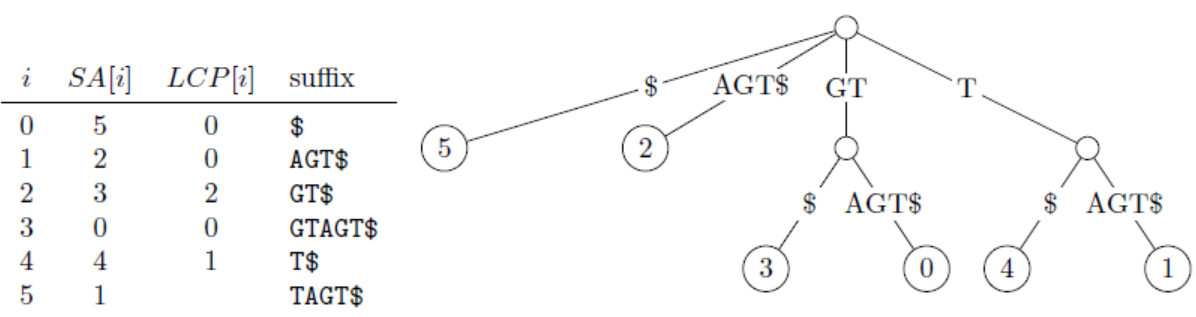

In [24]:
# test case
s = 'GTAGT$'
order = SuffixArray(s).order
lcp = LCP().ComputeLCPArray(s, order)
S = SuffixTree(s, order, lcp)
S.PrintEdges()
print('')
print(S.PatternMatching('AG'))
print(S.HasSuffix('AG'))


$
AGT$
GT
T
$
AGT$
$
AGT$

2
False
